In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd import Variable
from scipy.linalg import sqrtm
from tqdm import tqdm
import numpy as np
import os
from pytorch_fid import fid_score
from torchvision.models.inception import inception_v3
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import kagglehub
import os

In [ ]:
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Set parameters
IMG_SHAPE = (64, 64, 3)  # CelebA images resized to 64x64
LATENT_DIM = 100  # Size of the latent vector
BATCH_SIZE = 128
nz = 100
lr = 0.00025
beta1 = 0.5
epochs = 12


# Load and preprocess the CelebA dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Function to show images
def show_images(images, title="Images"):
    images = images[:25].detach().cpu()  # Move to CPU & detach from computation graph
    images = images * 0.5 + 0.5  # Unnormalize from [-1,1] to [0,1]

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True).numpy(), (1, 2, 0)))
    plt.show()

# Get a batch of real images
real_images, _ = next(iter(dataloader))
show_images(real_images[:49], title="Real Images")

In [ ]:


def to_device(data, device):
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

This section defines the Generator and Discriminator models for a Deep Convolutional GAN (DCGAN), following the architecture proposed in the original DCGAN paper.

> Discriminator
The Discriminator is a convolutional neural network that takes a 64×64 RGB image as input and outputs a single scalar indicating whether the image is real or fake.

Architecture Details:

Series of Conv2D layers with increasing channel sizes: 64 → 128 → 256 → 512

Uses LeakyReLU activations and Batch Normalization for stability

Final layer outputs a probability using a Sigmoid activation

No pooling layers are used; downsampling is done using stride

> Generator
The Generator takes a random noise vector of size nz and outputs a 64×64 RGB image.

Architecture Details:

Series of ConvTranspose2D (fractionally strided convolutions) to upscale the latent vector: nz → 512 → 256 → 128 → 64 → 3

Uses ReLU activations and Batch Normalization

Final layer uses a Tanh activation to scale the image pixels in the range [-1, 1]

> Model Initialization
Both models are initialized and moved to the selected computation device (CPU or GPU) using the to_device() utility.



In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)




# Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)



discriminator = to_device(Discriminator(), device)
generator = to_device(Generator(nz), device)





In [ ]:
# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

 Evaluation: FID Score and Metric Visualization
This section provides utility functions for evaluating the performance of generative models using FID (Fréchet Inception Distance) and for visualizing training progress.

> calculate_fid(real_images, fake_images)
This function computes the FID score, a popular metric to quantify the quality of generated images by comparing their feature statistics to real images.

Workflow:

Saves real and fake image tensors to temporary directories using torchvision.utils.save_image().

Calls fid_score.calculate_fid_given_paths() to compute FID based on Inception v3 features.

Cleans up by deleting temporary files and directories after computation.

Purpose:

Lower FID scores indicate that the generated images are more similar to the real ones in terms of distribution.

> plot_metrics(losses_g, losses_d, fid_scores)
This function generates plots to track the training process of the GAN:

Generator vs. Discriminator Losses:

Helps monitor adversarial training dynamics.

Generator tries to fool the discriminator, while the discriminator tries to detect fake images.

FID Score Over Time:

Helps assess image quality improvements.

FID is calculated every 2 epochs (or another specified interval).

Visualization Features:

Clean plots with labeled axes, gridlines, and legends for clarity.



In [ ]:
# Function to calculate FID
def calculate_fid(real_images, fake_images):
    # Save real and fake images to temporary directories
    real_dir = "temp_real"
    fake_dir = "temp_fake"
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    # Save real images
    for i, img in enumerate(real_images):
        vutils.save_image(img * 0.5 + 0.5, os.path.join(real_dir, f"real_{i}.png"), normalize=True)

    # Save fake images
    for i, img in enumerate(fake_images):
        vutils.save_image(img * 0.5 + 0.5, os.path.join(fake_dir, f"fake_{i}.png"), normalize=True)

    # Calculate FID
    fid_value = fid_score.calculate_fid_given_paths([real_dir, fake_dir], batch_size=BATCH_SIZE, device=device, dims=2048)

    # Clean up temporary directories
    for img_file in os.listdir(real_dir):
        os.remove(os.path.join(real_dir, img_file))
    for img_file in os.listdir(fake_dir):
        os.remove(os.path.join(fake_dir, img_file))
    os.rmdir(real_dir)
    os.rmdir(fake_dir)

    return fid_value


# Function to plot losses and FID scores
def plot_metrics(losses_g, losses_d, fid_scores):
    epochs = range(1, len(losses_g) + 1)

    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, losses_g, label="Generator Loss", marker="o")
    plt.plot(epochs, losses_d, label="Discriminator Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot FID scores
    fid_epochs = range(2, len(fid_scores) * 2 + 2, 2)
    plt.figure(figsize=(12, 6))
    plt.plot(fid_epochs, fid_scores, label="FID Score", marker="o", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.title("FID Scores Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

This section defines the core training loop for the DCGAN model, where the generator and discriminator are trained in an adversarial setup over multiple epochs. Additionally, FID scores are calculated periodically to monitor image quality progression.

> Adversarial Training
Discriminator Training:

Real Images: Labeled with soft labels (0.9 instead of 1.0) for improved training stability (label smoothing).

Fake Images: Generated by the generator and detached to prevent gradient flow into the generator during discriminator update.

The total discriminator loss is the sum of losses for real and fake batches.

Generator Training:

The generator attempts to create images that the discriminator classifies as real (0.9).

Its loss is based on how successfully it fools the discriminator.

> Loss Tracking
losses_g: Generator loss over epochs.

losses_d: Discriminator loss over epochs.

> FID Evaluation
Every 2 epochs, FID score is computed between real and generated images using the calculate_fid() function.

These scores are stored in fid_scores to be visualized later.

> Image Generation & Saving
Every 10 epochs, 25 generated images are saved as .png using torchvision.utils.save_image() for qualitative analysis.

At the end of training, a final batch of images is generated and displayed.

> Visualization
The training loop ends with a call to plot_metrics() to visualize:

Generator & Discriminator Losses

FID Scores over epochs



Epoch [1/12] Loss D: 0.9255, Loss G: 1.7813


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 115MB/s] 


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch [2/12], FID: 146.7156
Epoch [2/12] Loss D: 0.8574, Loss G: 1.4554
Epoch [3/12] Loss D: 0.9130, Loss G: 1.7632


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch [4/12], FID: 114.9734
Epoch [4/12] Loss D: 0.7732, Loss G: 2.3703
Epoch [5/12] Loss D: 0.7905, Loss G: 1.6722


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch [6/12], FID: 120.2545
Epoch [6/12] Loss D: 0.8064, Loss G: 1.7462
Epoch [7/12] Loss D: 0.8152, Loss G: 2.4172


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch [8/12], FID: 109.4271
Epoch [8/12] Loss D: 0.9127, Loss G: 1.0705
Epoch [9/12] Loss D: 0.7769, Loss G: 1.4433


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch [10/12], FID: 113.7674
Epoch [10/12] Loss D: 0.8217, Loss G: 3.3443
Epoch [11/12] Loss D: 0.9215, Loss G: 3.1436


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch [12/12], FID: 103.6507
Epoch [12/12] Loss D: 0.7681, Loss G: 2.1517


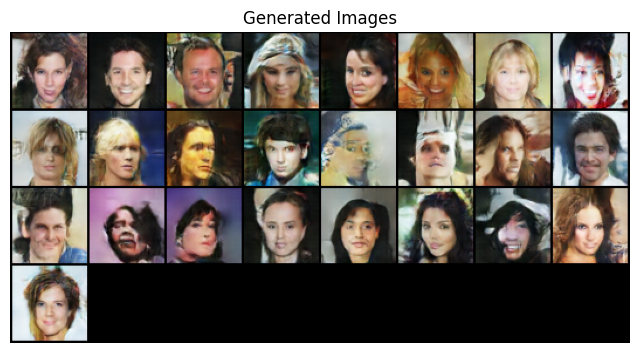

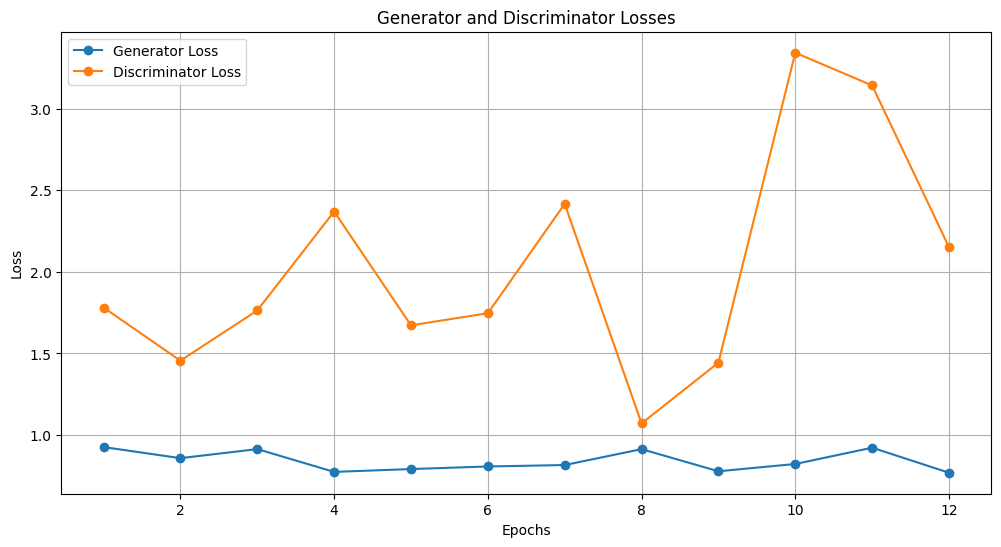

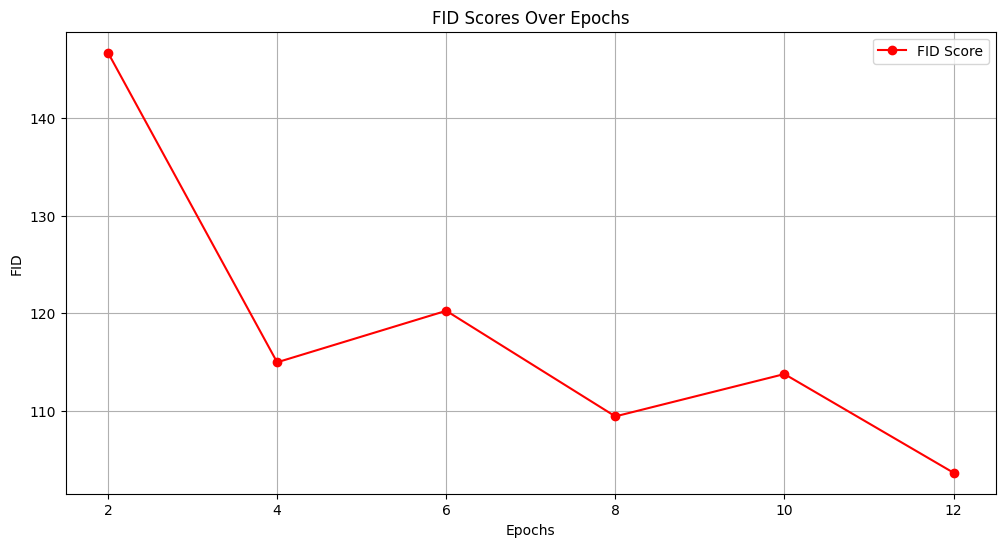

In [ ]:
    # Training Loop
losses_g = []
losses_d = []
fid_scores = []
for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
    
            # Train Discriminator
            real_labels = torch.full((batch_size,1), 0.9, device=device)
            fake_labels = torch.full((batch_size,1), 0.1, device=device)
    
            r_outputs = discriminator(real_images).view(-1, 1)
            loss_real = criterion(r_outputs, real_labels)
    
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise)
            f_outputs = discriminator(fake_images.detach()).view(-1, 1)
            loss_fake = criterion(f_outputs, fake_labels)
    
            loss_D = loss_real + loss_fake
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
    
            
            # Train Generator
            outputs = discriminator(fake_images).view(-1, 1)
            loss_G = criterion(outputs, real_labels)
    
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
    
        losses_g.append(loss_G.item())
        losses_d.append(loss_D.item())
    
        # caloculate FID
        if (epoch + 1) % 2 == 0:
            fid_value = calculate_fid(real_images, fake_images)
            fid_scores.append(fid_value)
            print(f"Epoch [{epoch+1}/{epochs}], FID: {fid_value:.4f}")
    
        print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
    
        if (epoch + 1) % 10 == 0:
            vutils.save_image(fake_images[:25], f"generated_{epoch+1}.png", normalize=True)
    
    
    # Generate fake images using trained generator
    noise = torch.randn(25, nz, 1, 1, device=device)  # Generate random noise
    fake_images = generator(noise)  # Pass noise through generator
    
    # Show fake images
    show_images(fake_images.detach().cpu(), title="Generated Images")
    
    plot_metrics(losses_d, losses_g, fid_scores)